# Module 2 Final Project - How Does Discount Impact Sales? 


### Northwind Database

<img src='Northwind_ERD.png'>

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

## The Deliverables

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be imporant information for the company. 

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test. 



In [148]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

from IPython.display import display, HTML

from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLSResults
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.formula.api as smf
import category_encoders as ce
from statsmodels.stats.power import TTestIndPower, FTestPower, FTestAnovaPower
from statsmodels.stats.outliers_influence import OLSInfluence


In [142]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))
        
def z_hbar(data, y_col, x_col, xlabel, title):
    colors = sns.color_palette("GnBu_d", 10)
    plt.figure(figsize=(8,7))
    ax = sns.barplot(y = data[y_col], x = data[x_col], data=data, orient='h', palette=colors, errwidth=0.8,
           capsize=0.2)
    ax.set_xlabel(xlabel=xlabel, fontsize=14)
    ax.set_xticks(np.arange(-0.5, 1.5))
    ax.set_ylabel(ylabel='Participants', fontsize=14)
    ax.set_title(label=title, fontsize=17)
    plt.tight_layout();

In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=False)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
con = engine.connect()
metadata = MetaData()

## What factors are related to increased sales and quantity?

- Assess discount for:
    * Discount vs Employee
    * Dicount vs Product
    * Discount vs Region
    * Discount vs Customer
    
- Take into consideration:
    * Hypotheses, FDR, power, beta, alpha
    * Interactions
    * Assumptions ANOVA (is using regression more robust?)
    * Effect sizes and estimated cost impacts

### DISCOUNT & QUANTITY

In [4]:
# Get names of tables in database
inspector.get_table_names()

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

### Does Discount Significantly Impact Order Quantity?

##### H0: Discount Has No Signficant Effect on Order Quantity
##### H1: Discount Does Significantly Increase Order Quantity

In [5]:
get_columns_info('Product')
print('\n')
get_columns_info('OrderDetail')
print('\n')
get_columns_info('Category')
print('\n')
get_columns_info('Order')

Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER


Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)


Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: D

In [6]:
product = pd.read_sql_query("""
SELECT o.CustomerId, o.EmployeeId, o.ShipRegion, od.Quantity, od.Discount, od.UnitPrice, o.Freight, 
        c.Id as CategoryId, c.CategoryName, ((p.UnitPrice * od.Quantity * (1 - od.Discount)) - Freight) as Revenue, 
        (p.UnitPrice * od.Quantity) as SalePrice
       
FROM [Order] o
    join OrderDetail od
    on od.OrderID = o.ID
    
    JOIN Product p
    on od.ProductID = p.ID
    
    JOIN Category c 
    on c.ID = p.CategoryID  

""", engine)              


In [7]:
product.isna().sum()

CustomerId      0
EmployeeId      0
ShipRegion      0
Quantity        0
Discount        0
UnitPrice       0
Freight         0
CategoryId      0
CategoryName    0
Revenue         0
SalePrice       0
dtype: int64

In [14]:
product.loc[product['Discount'] == 0.0, 'DiscountBinary'] = 0
product.loc[product['Discount'] > 0.0, 'DiscountBinary'] = 1

In [15]:
product.loc[product['Discount'] == 0.0, 'DiscountGrouped'] = 0
product.loc[(product['Discount'] > 0.0) & (product['Discount'] <= 0.05), 'DiscountGrouped'] = 1
product.loc[(product['Discount'] > 0.05) & (product['Discount'] <= 0.10), 'DiscountGrouped'] = 2
product.loc[(product['Discount'] > 0.10) & (product['Discount'] <= 0.15), 'DiscountGrouped'] = 3
product.loc[(product['Discount'] > 0.15) & (product['Discount'] <= 0.20), 'DiscountGrouped'] = 4
product.loc[(product['Discount'] > 0.20) & (product['Discount'] <= 0.25), 'DiscountGrouped'] = 5

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


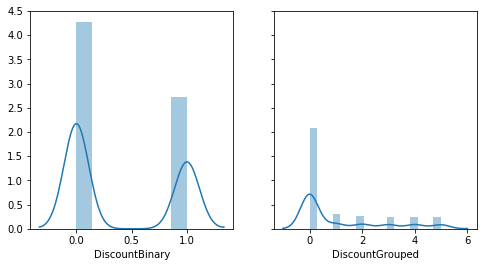

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(8, 4)

sns.distplot(product.DiscountBinary, ax=ax1)
sns.distplot(product.DiscountGrouped, ax=ax2);

2155


C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


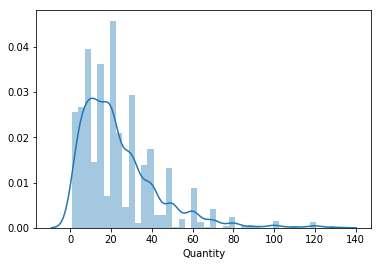

In [17]:
sns.distplot(product.Quantity)
print(len(product))

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


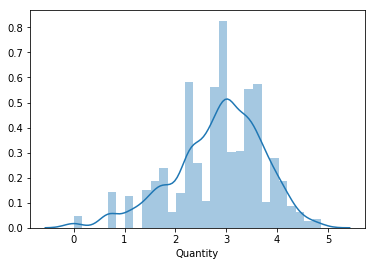

In [18]:
sns.distplot(np.log(product.Quantity))
product['LogQuantity'] = np.log(product.Quantity)

In [19]:
product.SalePrice.describe()

count     2155.000000
mean       672.560237
std       1110.261427
min          6.000000
25%        170.500000
50%        380.000000
75%        760.000000
max      15810.000000
Name: SalePrice, dtype: float64

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


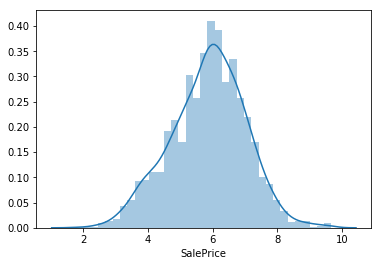

In [20]:
sns.distplot(np.log(product.SalePrice))
product['LogSales'] = np.log(product.SalePrice)

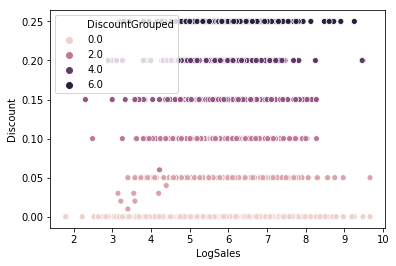

In [21]:
sns.scatterplot(x='LogSales', y='Discount', data=product, hue='DiscountGrouped')

In [22]:
product.head()

,CustomerId,EmployeeId,ShipRegion,Quantity,Discount,UnitPrice,Freight,CategoryId,CategoryName,Revenue,SalePrice,DiscountBinary,DiscountGrouped,LogQuantity,LogSales
0,VINET,5,Western Europe,12,0.0,14.0,32.38,4,Dairy Products,219.62,252.00,0.0,0.0,2.484907,5.529429
1,VINET,5,Western Europe,10,0.0,9.8,32.38,5,Grains/Cereals,107.62,140.00,0.0,0.0,2.302585,4.941642
2,VINET,5,Western Europe,5,0.0,34.8,32.38,4,Dairy Products,141.62,174.00,0.0,0.0,1.609438,5.159055
3,TOMSP,6,Western Europe,9,0.0,18.6,11.61,7,Produce,197.64,209.25,0.0,0.0,2.197225,5.343530
4,TOMSP,6,Western Europe,40,0.0,42.4,11.61,7,Produce,2108.39,2120.00,0.0,0.0,3.688879,7.659171


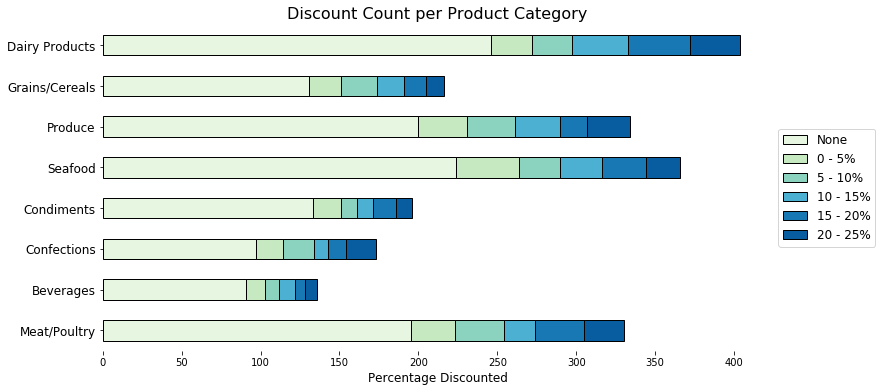

In [23]:
discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts().unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Discount Count per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

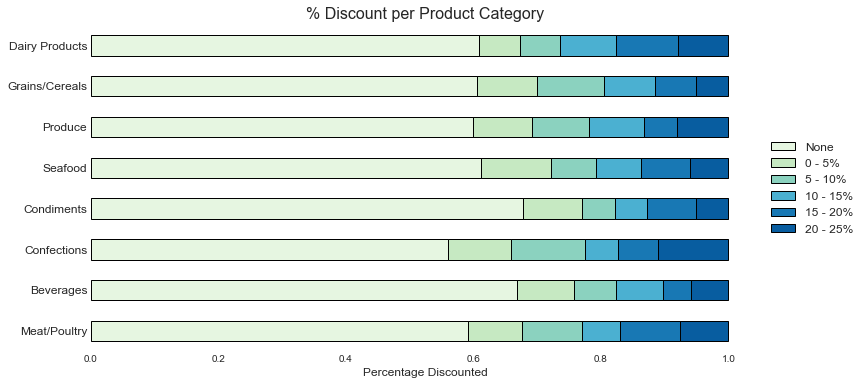

In [24]:
plt.style.use('seaborn-white')

discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts(normalize=True).unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('% Discount per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

In [25]:
print(product.groupby('CategoryName')['Discount'].agg(['mean', 'std']).round(3))

                 mean    std
CategoryName                
Beverages       0.062  0.088
Condiments      0.053  0.078
Confections     0.057  0.083
Dairy Products  0.053  0.081
Grains/Cereals  0.045  0.078
Meat/Poultry    0.064  0.089
Produce         0.045  0.077
Seafood         0.060  0.086


In [26]:
print(product.groupby(['DiscountGrouped'])['Quantity'].agg(['mean', 'std']).round(3))

                   mean     std
DiscountGrouped                
0.0              21.715  17.507
1.0              27.052  22.331
2.0              25.103  21.199
3.0              28.382  20.923
4.0              27.025  18.833
5.0              28.240  20.121


In [27]:
product.groupby(['DiscountBinary'])['Quantity'].mean()

DiscountBinary
0.0    21.715262
1.0    27.109785
Name: Quantity, dtype: float64

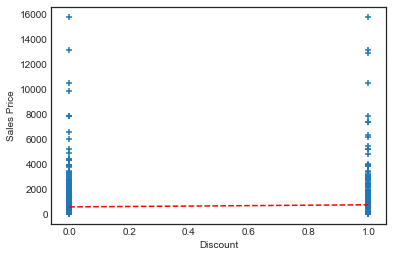

In [28]:
plt.scatter(product.DiscountBinary, product.SalePrice, marker = "+")
plt.plot([0, 1], [np.mean(product.query('DiscountBinary == 0').SalePrice), np.mean(product.query('DiscountBinary == 1').SalePrice)], 'r--')
plt.ylabel("Sales Price")
plt.xlabel("Discount")
plt.show()

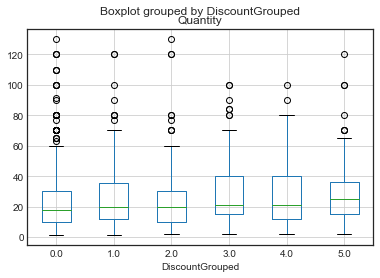

In [29]:
product.boxplot('Quantity', 'DiscountGrouped')

### Comparing Discount to No Discount 

Various OLS models were used to study the relationships between quantity, discount and sales. In most instances the models are not complete and the aim was not overall predictive accuracy, but rather establishing relationships (or lack thereof) between variables. Since the F-test of the OLS model is identical to ANOVA, OLS was preferred for it's enhanced flexibility (ability to combine categorical and continuous variables), improved robustness and better diagnostic tests, compared with traditional ANOVAs/ group analysis. 


In [30]:
product.Quantity.describe()

count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [31]:
from patsy.contrasts import Treatment

levels = [i for i in range(0, len(set(product.DiscountGrouped)))]
levels1 = [i for i in range(2)]

dummy_contrast = Treatment(reference=0).code_without_intercept(levels)
dummy_con_binary = Treatment(reference=0).code_without_intercept(levels1)

print(dummy_contrast.matrix)

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [32]:
reg = smf.ols('Quantity ~ C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     38.88
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           5.39e-10
Time:                        12:42:36   Log-Likelihood:                -9384.3
No. Observations:                2155   AIC:                         1.877e+04
Df Residuals:                    2153   BIC:                         1.878e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [33]:
reg = smf.ols('LogQuantity ~ C(DiscountBinary)', data = product).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            LogQuantity   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     38.57
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.34e-10
Time:                        12:42:36   Log-Likelihood:                -2748.0
No. Observations:                2155   AIC:                             5500.
Df Residuals:                    2153   BIC:                             5511.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [34]:
reg = smf.ols('Quantity ~ C(DiscountGrouped)', data = product).fit(cov_type='HC3')
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.408
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.90e-08
Time:                        12:42:37   Log-Likelihood:                -9382.6
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2149   BIC:                         1.881e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [35]:
reg = smf.ols('LogQuantity ~ C(DiscountGrouped)', data = product).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            LogQuantity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     8.604
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           4.40e-08
Time:                        12:42:37   Log-Likelihood:                -2745.8
No. Observations:                2155   AIC:                             5504.
Df Residuals:                    2149   BIC:                             5538.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

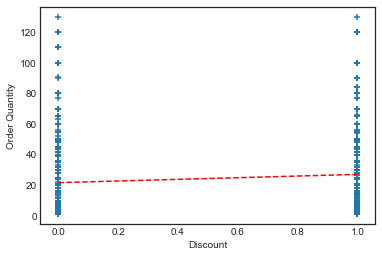

In [36]:
plt.scatter(product.DiscountBinary, product.Quantity, marker = "+")
plt.plot([0, 1], [np.mean(product.query('DiscountBinary == 0').Quantity), np.mean(product.query('DiscountBinary == 1').Quantity)], 'r--')
plt.ylabel("Order Quantity")
plt.xlabel("Discount")
plt.show()

###### INTERPRETATION

The F-test evaluates the significance of R2 compared to the null (nil) hypothesis, (i.e., that R2 is 0). A significant F statistic indicated that the amount of variance in Quantity accounted for by Discount is significantly different from 0. However, R2 also doubles as an effect size and as a percentage, only 2% of quantity can be accounted for by some Discount. 

Interpreting the above model, the intercept is the mean order quantity for the no discount category. This is confirmed by the descriptive statistics. For the remaining groups each beta value represents the comparison between that group and the no discount group (the specified reference group). For instance, the first contrast is no discount vs 1 - 5%; B = 5.3368 for this group and indicates that up to a 5% discount results in an approximate increase in quantity of 5. Likewise, for the second contrast, compared with no discount a 5 - 10% discount results in an increase in quantity of ~ 3. All categories of discount are significantly different from the no discount category. However, this does not indicate to us that all levels of discount are significant from each other. This is a very relevant question to ask because if a 5% discount produces the same increase in quantity and price for an order to a 25% discount, we could perhaps save money by only offering small discounts. 

Therefore, a follow up hypothesis is:

H0: All levels of discount are equal with regards to Quantity
H1: Levels of discount differ with regards to Quantity

Further investigation of the size of the discount on Quantity is carried out below. 

(Note on inference: It is important to take into consideration the proportion of each group to the entire sample, as R2 changes with the relevant size of each category to the whole. How does this generalize to the population? Also, shrunken R2 is a more reliable estimate of R.)

In [38]:
# Contrast only discount categories
from patsy.contrasts import Sum
from patsy.contrasts import Helmert

discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

sum_con_disc = Sum(omit=None).code_without_intercept(levels)
h_con_disc = Helmert().code_without_intercept(levels)

print(h_con_disc.matrix)
print('\n')
print(sum_con_disc.matrix)

[[-1. -1. -1. -1.]
 [ 1. -1. -1. -1.]
 [ 0.  2. -1. -1.]
 [ 0.  0.  3. -1.]
 [ 0.  0.  0.  4.]]


[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-1. -1. -1. -1.]]


In [39]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, sum_con_disc)', data = discount).fit(cov_type='HC3')
print(lm.summary())
print('\n')
print('C(DiscountGrouped, sum_con_disc)[S.4]     1.0797      1.450      0.745      0.457      -1.762       3.922')

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6532
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.625
Time:                        12:42:54   Log-Likelihood:                -3729.4
No. Observations:                 838   AIC:                             7469.
Df Residuals:                     833   BIC:                             7492.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

A sum contrast was used to compare each level of discount with all other levels (i.e., The mean quantity for each level of discount was compared with the combined mean quantity for all other levels). Significance testing indicates that level of discount accounted for no variance/ effect in Quantity, F = 0.65, p = 0.625. Therefore, individual contrasts will not be investigated and we can conclude that, while some discount is significantly related to Quantity, the level of discount is inconsequential. We therefore fail to reject the null, and accept that all levels of discount are equal with regards to Quantity. 

Now, to determine whether the increase in quantity accounted for by discount is substantial in a real world sense, and not only in a statistical sense, the overall price of the sale will be investigated. Sales Price was feature engineered from Unit Price * Quantity, and therefore contains information about quantity as well as overall value of the sale. This may therefore be a more informative metric for decision making with regards to what discount to offer customers in the future. 

H0: Discount does not significantly impact Sales Price (M sales price no discount = M sales price discount)
H1: Discount does significantly impact Sales Price ((M sales price no discount != M sales price discount)



##### Sales Price = Discount Binary

In [43]:
lm1 = smf.ols('SalePrice ~ C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     10.82
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00102
Time:                        12:43:21   Log-Likelihood:                -18163.
No. Observations:                2155   AIC:                         3.633e+04
Df Residuals:                    2153   BIC:                         3.634e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [44]:
lm = smf.ols('LogSales ~ C(DiscountBinary)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     22.60
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.12e-06
Time:                        12:43:30   Log-Likelihood:                -3375.0
No. Observations:                2155   AIC:                             6754.
Df Residuals:                    2153   BIC:                             6765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

##### Sales Price = Levels of Discount

In [45]:
# Contrast only discount categories

discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

sum_con_disc = Sum(omit=0).code_without_intercept(levels)
h_con_disc = Helmert().code_without_intercept(levels)

print(h_con_disc.matrix)
print('\n')
print(sum_con_disc.matrix)

[[-1. -1. -1. -1.]
 [ 1. -1. -1. -1.]
 [ 0.  2. -1. -1.]
 [ 0.  0.  3. -1.]
 [ 0.  0.  0.  4.]]


[[-1. -1. -1. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [46]:
lm = smf.ols('SalePrice ~ C(DiscountGrouped, sum_con_disc)', data = discount).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.664
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.156
Time:                        12:44:03   Log-Likelihood:                -7159.2
No. Observations:                 838   AIC:                         1.433e+04
Df Residuals:                     833   BIC:                         1.435e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [49]:
lm = smf.ols('LogSales ~ C(DiscountGrouped, sum_con_disc)', data = discount).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7741
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.542
Time:                        12:45:46   Log-Likelihood:                -1317.6
No. Observations:                 838   AIC:                             2645.
Df Residuals:                     833   BIC:                             2669.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

The above two analyses indicate that on average, there was a $168.75 increase in Sales Price when a discount was offered. However, as for Quantity, the level of discount offered did not significantly impact Sales Price. Therefore, based on these analyses we can consider offering a discount of 1 - 5%. 

Discounts > 5% = 87 448.93 Euros, or 6.03% of total sales. Therefore, this could potentially be saved if smaller discounts are as effective as larger ones in increasing the number of items ordered/ overall price of the sale. 


In [ ]:
# to calculate savings figures above

#savings = product.loc[product['DiscountGrouped'] > 1]
#discounts = savings.Discount * savings.SalePrice
#(discounts.sum()/ product.SalePrice.sum()) * 100

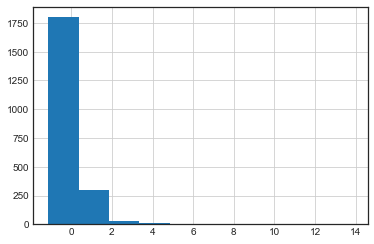

In [144]:
test_class = OLSInfluence(lm)
influence = test_class.summary_frame()
influence.standard_resid.hist()

In [ ]:
# tests of homogeneity when transformed and not transformed 

#### Region, Category and Employee in relation to Quantity, Sales and Discounts

Interactions are partialed effects (contribution to R2 over and above the main effects of discount and category).

In this instance category represents a fixed effect as it represents all categories of product available for this company and our conclusions apply only to these conditions of discount and category. Therefore, the interactions test the hypothesis that disocunt (and levels of discount) uniformly affect categories of product. Our alternative hypothesis is that discount does not unifromly affect the Sales of each category, and that there are indeed differences in Sales due to discount and subcategories of discount. 

This analysis will help to refine our decisions regarding:
i) Whether offering discounts benefits sales
ii) What level of discount best benefits sales

Should we find that sales within certain categories are more or less affected by discount, and specific levels of discount, this will allow a more nuanced approach to discount. 

In [146]:
product.groupby('CategoryId')['CategoryName'].value_counts()

CategoryId  CategoryName  
1           Beverages         404
2           Condiments        216
3           Confections       334
4           Dairy Products    366
5           Grains/Cereals    196
6           Meat/Poultry      173
7           Produce           136
8           Seafood           330
Name: CategoryName, dtype: int64

In [139]:
from patsy.contrasts import Sum

levels = [i for i in range(len(set(product.CategoryId)))]
levels1 = [i for i in range(len(set(product.DiscountGrouped)))]

sum_con_cat = Sum().code_without_intercept(levels)
dummy_con_cat = Treatment(reference=0).code_without_intercept(levels)
sum_con_disc = Sum(omit=0).code_without_intercept(levels1)

print('Sum Contrast Matrix - Categories\n', sum_con_cat.matrix, end='\n\n')
print('Dummy Contrast Matrix - Categories\n', dummy_con_cat.matrix)

Sum Contrast Matrix - Categories
 [[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [-1. -1. -1. -1. -1. -1. -1.]]

Dummy Contrast Matrix - Categories
 [[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [120]:
# Category to Quantity, Sales and Discount
lm = smf.ols('SalePrice ~ C(CategoryName, sum_con_cat) + C(DiscountBinary)', data = product).fit()
print(lm.summary())
print('\n')
print('C(CategoryName, sum_con_cat)[S.7]  -242.8040     58.176     -4.174      0.000    -356.892    -128.716')


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.219
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           5.15e-11
Time:                        09:34:27   Log-Likelihood:                -18136.
No. Observations:                2155   AIC:                         3.629e+04
Df Residuals:                    2146   BIC:                         3.634e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Note that here the binary discount variable represents the difference between discount and no discount for the unweighted mean of the discount and no discount groups for each of the categories. The coefficients may therefore differ to before when category wasn't included. However, the interpretation then is specific to Sales within categories with regards to discount. 

In [165]:
# particularly in relation to discount that we are interested
lm = smf.ols('SalePrice ~ C(DiscountBinary) * C(CategoryName, sum_con_cat)', data = product).fit(cov_type='HC3')
print(lm.summary())
print('\n')
print('C(DiscountGrouped)[T.1.0]:C(CategoryName, sum_con_cat)[S.7]  -261.0766    138.203     -1.889      0.059    -531.950       9.797'
'C(DiscountGrouped)[T.2.0]:C(CategoryName, sum_con_cat)[S.7]   -51.0310     95.611     -0.534      0.594    -238.425     136.363'
'C(DiscountGrouped)[T.3.0]:C(CategoryName, sum_con_cat)[S.7]    75.0655    157.194      0.478      0.633    -233.029     383.160'
'C(DiscountGrouped)[T.4.0]:C(CategoryName, sum_con_cat)[S.7]   220.7109    142.485      1.549      0.121     -58.555     499.976'
'C(DiscountGrouped)[T.5.0]:C(CategoryName, sum_con_cat)[S.7]  -222.4185    139.436     -1.595      0.111    -495.708      50.871')

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     6.335
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           2.44e-13
Time:                        12:51:24   Log-Likelihood:                -18134.
No. Observations:                2155   AIC:                         3.630e+04
Df Residuals:                    2139   BIC:                         3.639e+04
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

Changes in effect/ significance due to transformation of Y warrant investigation for final descisions on what to accept. 

In [154]:
print(product.groupby(['CategoryName', 'CategoryId', 'DiscountGrouped'])['SalePrice'].mean())

CategoryName    CategoryId  DiscountGrouped
Beverages       1           0.0                 661.521341
                            1.0                1872.038462
                            2.0                 613.270000
                            3.0                 455.347222
                            4.0                1102.967949
                            5.0                 732.343750
Condiments      2           0.0                 491.999237
                            1.0                 668.102500
                            2.0                 471.934783
                            3.0                 830.152941
                            4.0                 585.346429
                            5.0                1033.372727
Confections     3           0.0                 577.524050
                            1.0                 680.040323
                            2.0                 394.215333
                            3.0                 670.104828
            

```
OLS Regression Results                           
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.669
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           9.67e-09
Time:                        08:36:10   Log-Likelihood:                -18104.
No. Observations:                2155   AIC:                         3.630e+04
Df Residuals:                    2107   BIC:                         3.658e+04
Df Model:                          47                                         
Covariance Type:                  HC3                                         
===================================================================================================================
                                                  coef      std err        z        P>|z|     [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                       628.2459     27.435     22.900      0.000     574.475     682.017
C(DiscountGrouped)[0 - 5%  vs  0]               251.0962    122.488      2.050      0.040      11.024     491.169
C(DiscountGrouped)[5 - 10%  vs 0]               70.3634     68.847      1.022      0.307     -64.574     205.301
C(DiscountGrouped)[10 - 15% vs 0]               108.2659     77.604      1.395      0.163     -43.835     260.367
C(DiscountGrouped)[15 - 20% vs 0]               80.1919     90.890      0.882      0.378     -97.949     258.333
C(DiscountGrouped)[20 - 25% vs 0]               307.7906    111.321      2.765      0.006      89.606     525.975

C(Confections vs All Other Categories)          -50.7218     51.000     -0.995      0.320    -150.679      49.236

C(DiscountGrouped)[0 - 5% vs 0]:C(Confections)  -148.5800    190.151     -0.781      0.435    -521.270     224.110
C(DiscountGrouped)[5-10%  vs 0]:C(Confections)  -253.6721    106.945     -2.372      0.018    -463.281     -44.063
C(DiscountGrouped)[10-15% vs 0]:C(Confections)   -15.6851    150.139     -0.104      0.917    -309.952     278.582
C(DiscountGrouped)[15-20% vs 0]:C(Confections)  -297.7024    130.659     -2.278      0.023    -553.790     -41.615
C(DiscountGrouped)[20-25% vs 0]:C(Confections)  -279.2869    145.675     -1.917      0.055    -564.805       6.232

```


```
         Confections     
Discount            Mean Sales
------------------------------
[0] None                577.524050
[1] 0 > to 5%           680.040323
[2] 5 - 10%             394.215333
[3] 10 - 15%            670.104828
[4] 15 - 20%            360.013529
[5] 20 - 25%            606.027778
------------------------------

```


For all categories, only one - Confections - indicated a significant difference for discount vs no discount conditions. This interaction was followed up with a more detailed analysis of the levels of discount that may be responsible for the observed difference. Once again, each level of discount was compared with the no discount condition to test the null hypothesis:

H0: Discounted and non-discounted sales were equivalent

Discounts between 5 and 10% were related to significantly less sales for Confections. To understand the coefficient within the regression equation:

The regression equation for the 5-10% discount condition on Confections:
Y = B0 + B1*X + B2*X + B3*X, 

where B0 (Intercept) = 628.25, B1(Category Main Effect) = -50.72, B2(Discount Main Effect) = 70.36, 
      B3(Category*Discount Interaction) = -253.67

The mean difference between Confections and all other categories is 628.2459 + (-50.7218) = 577.5241
The mean difference in 5-10% vs no discount comparison for all categories is: 577.5241 + 70.3624 = 647.8865

The mean for 5 - 10% discount for Confections is: 647.8865 + (-253.6721) = 394.214.

Therefore, although sales were generally lower for confections compared with other product categories, this difference was not significant. However, relative to other categories, Confections were more likely to have reduced sales when discounts of either 5-10% and 15-20% were offered. Even though the 20-25% category of discount was not significant, we see a similar trend towards significance and reduced sales. 

Looking at the means for Confections and levels of discount, it's obvious that Sales were higher for the 20 - 25% bracket compared with the no discount bracket for Confections. It is important to interpret the coefficients here appropriately:
Despite higher sales within Confections, when this category is compared with other categories for this level of discount, there is a relative reduction in Sales of $279.29. Likewise, when compared with all other categories, there was a relative reduction in sales for the other two discount categories.   

When we run a set of significance tests on Confections below it shows a non significant effect for discount on sales. This test was adequately powered for a 0.2 and up effect size; therefore any effect smaller than 0.2 may not be detected due to sample size, but arguably, such a small effect is of no significance anyway. 

In conclusion then, while Sales overall were significantly increased for some discount compared with no discount, the effect size for this increase was small. The level of discount offered did not appear to increase Sales for any one category. Cpmpared with all other categories, certain levels of discount appeared to be related to less Sales for Confections. My suggestion based on this is to keep discount to a minimum level across all categories. 



In [175]:
FTestPower().solve_power(effect_size=0.2, df_num=328, df_denom=5, alpha=0.05)

0.8108318932733938

In [166]:
confections = product.loc[product['CategoryId'] == 3]
lm = smf.ols('SalePrice ~ C(DiscountGrouped)', data = confections).fit(cov_type='HC3')
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.876
Date:                Wed, 19 Dec 2018   Prob (F-statistic):             0.0981
Time:                        12:52:49   Log-Likelihood:                -2647.7
No. Observations:                 334   AIC:                             5307.
Df Residuals:                     328   BIC:                             5330.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

The above indicates that Sales and Quantity did not differ as a function of product category. 

Furthermore, there were no interaction effects for category by discount - offering a discount did not impact the quantity sold for any category (compared with all other categories). So no categories stood out in terms of discount on quantity. 

However, offering a discount did influence the overall sales price for seafood compared with other categories. In particular, the mean Sales Price for discounted condiments was 189.41 Euro more (M = 681.07) than non discounted condiments (M = 492.00), when a discount was offered. 

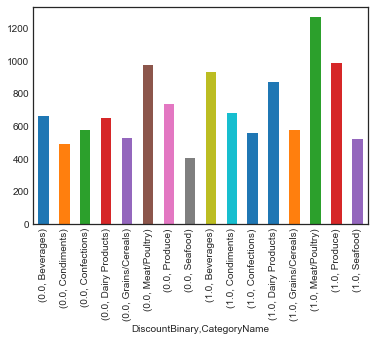

In [63]:
product.groupby(['DiscountBinary', 'CategoryName'])['SalePrice'].mean().plot(kind='bar')
#product.groupby(['CategoryName'])['SalePrice'].mean()
#product.groupby(['DiscountBinary'])['SalePrice'].mean()
#product['SalePrice'].mean()
#product.groupby(['CategoryName','DiscountGrouped']).mean()

In [64]:
def boxplot(data, x, y, xlabel, ylabel, title):
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
    fig, axes = plt.subplots(1, figsize=(9,6))
    sns.boxplot(x=x, y=y, data=data, ax=axes, palette=("husl"), boxprops=dict(alpha=.8), 
                showmeans=True, meanprops=meanpointprops)
    sns.swarmplot(x=x, y=y, data=data, color="grey", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14);

Finally, it's important to understand how important quantity is to predicting Sales. Both Quantity and Sales come from skewed distributions (see below). Square root and log transforming these distributions does help reduce the influence of outliers. However, it is not certain whether assuming a Gaussian distribution for Sales Price and Quantity improves prediction and understanding of what is driving these variables.  

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


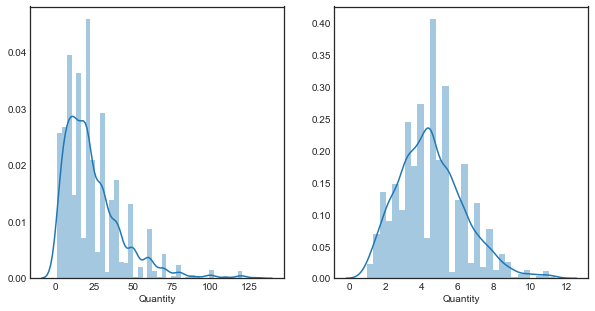

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

sns.distplot(product.Quantity, ax=ax1)
sns.distplot(np.sqrt(product.Quantity), ax=ax2);

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


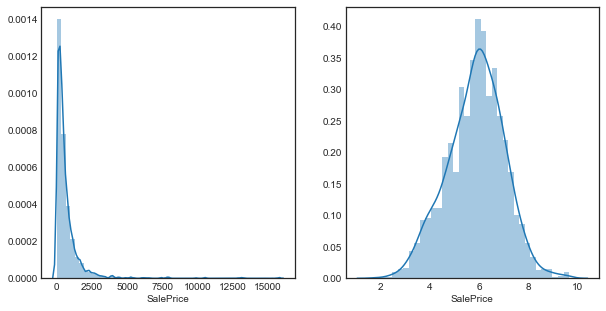

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

sns.distplot(product.SalePrice, ax=ax1)
sns.distplot(np.log(product.SalePrice), ax=ax2);


In [67]:
from patsy.contrasts import Sum

levels = [i for i in range(len(set(product.CategoryId)))]

sum_contrast = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [-1. -1. -1. -1. -1. -1. -1.]]


In [70]:
lm = smf.ols('Quantity ~ C(CategoryId, sum_contrast)', data = product).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5174
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.822
Time:                        14:38:45   Log-Likelihood:                -9403.3
No. Observations:                2155   AIC:                         1.882e+04
Df Residuals:                    2147   BIC:                         1.887e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

                              Quantity                                       \
                                 count   mean    std  min   25%   50%   75%   
CategoryName   DiscountBinary                                                 
Beverages      0.0               246.0  20.80  16.54  2.0  10.0  19.0  30.0   
               1.0               158.0  27.95  22.15  2.0  12.0  20.5  39.0   
Condiments     0.0               131.0  21.32  15.27  1.0  10.0  20.0  30.0   
               1.0                85.0  29.47  24.46  1.0  12.0  20.0  35.0   
Confections    0.0               200.0  23.09  17.84  1.0  10.0  20.0  30.0   
               1.0               134.0  24.54  16.39  1.0  12.0  21.0  35.0   
Dairy Products 0.0               224.0  22.17  17.18  1.0  10.0  20.0  30.0   
               1.0               142.0  29.46  20.38  2.0  15.0  24.0  42.0   
Grains/Cereals 0.0               133.0  22.74  18.45  2.0   9.0  20.0  30.0   
               1.0                63.0  24.40  17.92

In [ ]:
print(product.Quantity.mean())
print(product.SalePrice.mean())

In [ ]:
product.groupby('PriceLevels')['Quantity'].describe().round(3)


In [ ]:
product.groupby('ShipRegion').mean()

In [ ]:
# Does Discount vary significantly by Region?
levels = [i for i in range(len(set(product.EmployeeId)))]

sum_con_emp = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

In [ ]:
lm = smf.ols('LogQuantity ~ C(EmployeeId, sum_con_emp)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('LogQuantity ~ C(EmployeeId, sum_con_emp) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('LogSales ~ C(EmployeeId, sum_con_emp) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('LogSales ~ C(EmployeeId, sum_con_emp)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm = smf.ols('Quantity ~ DiscountAmount * C(CategoryId)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
employee_contrast = product.loc[product['EmployeeId'] == 8]

In [ ]:
product['SalesRatio'] = product.ExtendedPrice/product.SalePrice
product['DiscountAmount'] = product.Discount * product.SalePrice

In [ ]:
product.DiscountAmount.hist()

In [ ]:
product.DiscountAmount.describe()

In [ ]:
product.groupby('EmployeeId')['SalesRatio'].mean()

In [ ]:
len(employee_contrast)
employee_contrast.groupby('DiscountGrouped')['SalePrice'].mean().plot();

In [ ]:
product.groupby('DiscountGrouped')['SalePrice'].median().plot()

In [ ]:
levels = [i for i in range(len(set(employee_contrast.CategoryId)))]

sum_con = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

In [ ]:
lm = smf.ols('SalePrice ~ C(DiscountBinary) * C(CategoryId, sum_con)', data = employee_contrast).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
product.groupby(['EmployeeId', 'DiscountBinary'])['Quantity', 'SalePrice'].mean()

In [ ]:
product['Sale_z'] = (product['SalePrice'] - product['SalePrice'].mean())/ product.SalePrice.std()

In [ ]:
z_hbar(product, 'EmployeeId', 'Sale_z', 'Employee Sales', 'Employee Sales Standardized')

In [ ]:
z_hbar(product, 'EmployeeId', 'SalePrice', 'Employee Sales', 'Employee Sales')

In [ ]:
levels = [i for i in range(len(set(product.ShipRegion)))]

sum_con_ship = Sum().code_without_intercept(levels)

print(sum_contrast.matrix)

In [ ]:
lm = smf.ols('Quantity ~ C(ShipRegion, sum_con_ship)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
lm2 = smf.ols('LogQuantity ~ C(ShipRegion, sum_con_ship) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
test_class = OLSInfluence(lm2)
influence = test_class.summary_frame()
influence.standard_resid.hist()

In [ ]:
lm = smf.ols('LogSales ~ C(ShipRegion, sum_con_ship) * C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
product.groupby('ShipRegion')['SalePrice', 'Quantity', 'Freight'].mean().round(2)

In [ ]:
lm = smf.ols('Freight ~ C(ShipRegion) * ', data = product).fit(cov_type='HC3')
print(lm.summary())

In [ ]:
sns.distplot(OLSResults.resid(new));
OLSResults.resid(new).mean()

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
test_class = OLSInfluence(lm)
test_class.dfbetas[:5,:]

In [ ]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

In [ ]:
dir(test_class);

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(lm.resid, lm.model.exog)
list(zip(name, test))

In [ ]:
product.Quantity[1363]
product.Quantity[1621]

In [ ]:
# GLM 

formula = """SalePrice ~ C(DiscountBinary)"""
response, predictors = dmatrices(formula, product, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit(cov_type='HC3')
print(po_results.summary())

In [ ]:
lm = smf.ols('ExtendedPrice ~ Quantity', data = product).fit()
print(lm.summary())

In [ ]:
lm = smf.ols('Quantity ~ OrderPrice', data = product).fit()
print(lm.summary())

In [ ]:
product.head()

In [ ]:
from patsy.contrasts import Treatment

levels = [1,2,3,4,5,6]

contrast = Treatment(reference=0).code_without_intercept(levels)

print(contrast.matrix)

In [ ]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, contrast)', data = product).fit()
print(lm.summary())

In [ ]:
len(product.CategoryId.unique())

In [ ]:
from patsy.contrasts import Helmert

helmert = Helmert().code_without_intercept(levels)

print(helmert.matrix)

In [ ]:
lm = smf.ols('Quantity ~ C(DiscountGrouped, contrast)', data = product).fit()
print(lm.summary())

In [168]:
effect_size = 0.4
alpha = 0.05 # significance level
power = 0.8

power_analysis = FTestAnovaPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 51.05


In [169]:
smp.FTestPower().solve_power(effect_size=0.1, df_num=2147, df_denom=7, alpha=0.05)

NameError: name 'smp' is not defined

In [ ]:
def ols_categorical_analysis_list(list_df, DV, CV, contrast=None, omit=0, 
                             CV2=None, contrast2=None, omit2=0, 
                             NV=None, alpha=0.05, 
                             power=0.8, effect=0.25, cov_type=None,
                             start=0, col1=0, col2=None):
    
    for ind, df in enumerate(list_df, start=start):
        
        # contrast matrix
        levels = [i for i in range(0, len(set(df[CV])))]
        #contrast = Dummy
        con_CV = Sum(omit=omit).code_without_intercept(levels)
        print(con_CV)
        
        # formula
        if CV2 != None:
            levels1 = [i for i in range(len(set(df[CV2])))]
            contrast2 = contrast2.upper()
            con_CV2 = contrast2(omit=omit).code_without_intercept(levels1)
        
        if CV2 == None and NV == None:
            formula = '{} ~ C({}, {})'.format(DV, CV, con_CV)
        elif CV2 != None and NV == None:
            formula = '{} ~ C({}, {}) * C({}, {})'.format(DV, CV, con_CV, CV2, con_CV2)
        elif CV2 == None and NV != None:
            formula = '{} ~ C({}, {}) * {}'.format(DV, CV, con_CV, NV)
        else:
            formula = '{} ~ C({}, {}) * C({}, {}) * {}'.format(DV, CV, con_CV, CV2, con_CV2, NV)
        
        
        lm = smf.ols(formula, data = df).fit(cov_type=cov_type)
        df1 = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df1.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        
        # Output
        print(i[CV].unique())
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df1.iloc[:,col1:col2])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))

    # calculate required sample size for specified power and alpha values 
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect, 
                                         power = power, 
                                         alpha = alpha)
    print('Required sample size for power {} and effect size {}: {}'.format(power, effect, round(sample_size)))

Further investigation before final decision:
1) Is the effect of discount on Quantity or Sales Price modulated by time? In other words, does offering larger discounts earlier on result in more sales over time for any customers? 